# This code is to get the labeled_energy_data csv file of each model

## 对数据进行分析,展示出来的内容包括:
### 1. 每个模型在 5 个 epochs 下的每个能耗数据点

## Import the lib

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

## Function in use

### load the interpolate function

In [2]:
def integrate_power_over_interval(samples, start_time, end_time):
    # 假定 samples是按时间升序排序的 (t, p)
    # 若未排序，请先排序:
    # samples = sorted(samples, key=lambda x: x[0])
    
    def interpolate(samples, target_time):
        # 在 samples 中找到 target_time 左右最近的两个点，并进行线性插值
        # 若 target_time 恰好等于某个样本点时间，直接返回该点功率
        # 若无法找到两侧点（如 target_time在样本时间轴外），根据情况返回None或边界点
        n = len(samples)
        if n == 0:
            return None
        # 若 target_time 小于第一个样本点时间，无法向左插值，这里直接返回第一个点的功率值(或None)
        if target_time <= samples[0][0]:
            # 简化处理：返回最早样本点的功率（或None）
            return samples[0][1]
        # 若 target_time 大于最后一个样本点时间，无法向右插值，返回最后一个点的功率（或None）
        if target_time >= samples[-1][0]:
            return samples[-1][1]

        # 否则，在中间插值
        # 使用二分查找快速定位
        import bisect
        times = [t for t, _ in samples]
        pos = bisect.bisect_left(times, target_time)
        # pos是使times保持有序插入target_time的位置
        # 因为target_time不在已有样本点中，pos不会越界且pos>0且pos<n
        t1, p1 = samples[pos-1]
        t2, p2 = samples[pos]
        # 线性插值： p = p1 + (p2 - p1)*((target_time - t1)/(t2 - t1))
        ratio = (target_time - t1) / (t2 - t1)
        p = p1 + (p2 - p1)*ratio
        return p

    # 从原始 samples 中筛选出位于[start_time, end_time]内的点
    filtered = [(t, p) for t, p in samples if start_time <= t <= end_time]

    # 如果不足2个点，则尝试使用插值
    if len(filtered) < 2:
        # 无论如何都需要在边界处插值出两个点(起码start和end)
        start_power = interpolate(samples, start_time)
        end_power = interpolate(samples, end_time)

        # 如果从样本中无法插值出任何有意义的点（比如samples为空或无法插值），返回0.0
        if start_power is None or end_power is None:
            return 0.0

        # 将插值的边界点加入到 filtered
        # 注意：如果filtered中有一个点在区间内，我们也需要确保边界有两点以上
        # 例如filtered只有一个点在中间，则需要在start和end插值点全部加入。
        # 若filtered为空，则只用start/end两点插值点求积分
        new_filtered = [(start_time, start_power)] + filtered + [(end_time, end_power)]
        # 确保按时间排序
        new_filtered.sort(key=lambda x: x[0])
        filtered = new_filtered

    # 正常积分计算
    if len(filtered) < 2:
        # 经过插值仍不够，返回0
        return 0.0

    total_energy = 0.0
    for i in range(len(filtered)-1):
        t1, p1 = filtered[i]
        t2, p2 = filtered[i+1]
        dt = t2 - t1
        avg_p = (p1 + p2)/2.0
        total_energy += avg_p * dt

    return total_energy

### Read the data

In [3]:
def load_data(model_path):
    # load the csv files 
    energy_data = pd.read_csv(os.path.join(model_path, 'energy_consumption_file.csv'))
    labeled_energy_data = pd.read_csv(os.path.join(model_path, 'labeled_energy_data.csv'))

    # load the npy files
    to_device = np.load(os.path.join(model_path, 'to_device.npy'), allow_pickle=True)
    forward = np.load(os.path.join(model_path, 'forward.npy'), allow_pickle=True)
    loss = np.load(os.path.join(model_path, 'loss.npy'), allow_pickle=True)
    backward = np.load(os.path.join(model_path, 'backward.npy'), allow_pickle=True)
    optimize = np.load(os.path.join(model_path, 'optimize.npy'), allow_pickle=True)

    # load the energy data
    to_device_energy = np.load(os.path.join(model_path, 'to_device_energy.npy'), allow_pickle=True)
    forward_energy = np.load(os.path.join(model_path, 'forward_energy.npy'), allow_pickle=True)
    loss_energy = np.load(os.path.join(model_path, 'loss_energy.npy'), allow_pickle=True)
    backward_energy = np.load(os.path.join(model_path, 'backward_energy.npy'), allow_pickle=True)
    optimize_energy = np.load(os.path.join(model_path, 'optimize_energy.npy'), allow_pickle=True)
    
    return energy_data, labeled_energy_data, to_device, forward, loss, backward, optimize, \
            to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy

### preset the color and marker

In [4]:
# Create a color map and marker map for the steps
step_colors = {
    'idle': 'gray',
    'to_device': 'blue',
    'forward': 'green',
    'loss': 'red',
    'backward': 'purple',
    'optimize': 'orange'
}
step_markers = {
    'idle': 'o',
    'to_device': 's',
    'forward': '^',
    'loss': 'D',
    'backward': 'x',
    'optimize': 'P'
}

### Plot the energy data of each sample with scatter plot and line plot

In [5]:
def plot_energy_data(labeled_energy_data):
    # Plot the data with a larger figure size
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot each step with a different marker
    for step in step_colors.keys():
        step_data = labeled_energy_data[labeled_energy_data['step'] == step]
        ax.scatter(step_data['timestamp'], step_data['power_in_watts'], color=step_colors[step], label=step, s=5, marker=step_markers[step])

    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Power in Watts')
    ax.legend()
    plt.show()

    # Create a new figure and axis
    fig, ax = plt.subplots(figsize=(12,6))

    # Plot each step with a different color
    for step in step_colors.keys():
        step_data = labeled_energy_data[labeled_energy_data['step'] == step]
        if step != 'idle':
            ax.plot(step_data['timestamp'], step_data['power_in_watts'], color=step_colors[step], label=step)

    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Power in Watts')
    ax.legend()
    plt.show()

### Plot the energy data of a time period with scatter plot

In [6]:
def plot_period_energy_data(labeled_energy_data):
    # Create a new figure and axis
    fig, ax = plt.subplots(figsize=(12,8))

    labeled_energy_data_rows = labeled_energy_data[2000:2200]

    # Plot each step with a different color, except 'optimize' and 'loss'
    for step in step_colors.keys():
        if step not in ['optimize', 'loss']:
            step_data = labeled_energy_data_rows[labeled_energy_data_rows['step'] == step]
            ax.scatter(step_data['timestamp'], step_data['power_in_watts'], color=step_colors[step], label=step)

    # Plot 'optimize' and 'loss' steps last to ensure they are on top
    for step in ['optimize', 'loss']:
        step_data = labeled_energy_data_rows[labeled_energy_data_rows['step'] == step]
        ax.scatter(step_data['timestamp'], step_data['power_in_watts'], color=step_colors[step], label=step)

    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Power in Watts')
    ax.legend()
    plt.show()

### plot each step energy data in each batch

In [7]:
def plot_batch_step_energy(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy):
    batch_info = ['to_device', 'forward', 'loss', 'backward', 'optimize']
    energy_data_dict = {
        'to_device': to_device_energy,
        'forward': forward_energy,
        'loss': loss_energy,
        'backward': backward_energy,
        'optimize': optimize_energy
    }

    # plot the energy consumption for each step
    fig, ax = plt.subplots(figsize=(10,6))
    for step in batch_info:
        energy_data = energy_data_dict[step]
        energy_consumption = [energy_data[epoch][batch][2] for epoch in range(to_device_energy.shape[0]) for batch in range(to_device_energy.shape[1])]
        ax.plot(range(len(energy_consumption)), energy_consumption, color=step_colors[step], label=step)

    ax.set_xlabel('Batch Index(Total 5 Epochs)')
    ax.set_ylabel('Energy Consumption per batch in Joules')
    ax.legend()
    plt.show()

### plot each step energy data with all batch with the x axis set to each step

In [8]:
def plot_step_energy_distribution(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy):
    batch_info = ['to_device', 'forward', 'loss', 'backward', 'optimize']
    energy_data_dict = {
        'to_device': to_device_energy,
        'forward': forward_energy,
        'loss': loss_energy,
        'backward': backward_energy,
        'optimize': optimize_energy
    }

    # plot the energy consumption for each step using dots
    fig, ax = plt.subplots(figsize=(10, 6))

    # Calculate the average energy consumption for each step
    average_energy_consumption = {step: np.mean([energy_data[epoch][batch][2] for epoch in range(to_device_energy.shape[0]) for batch in range(to_device_energy.shape[1])]) for step, energy_data in energy_data_dict.items()}

    # Plot each step's energy consumption as a dot on the corresponding x-axis
    for i, step in enumerate(batch_info):
        energy_data = energy_data_dict[step]
        energy_consumption = [energy_data[epoch][batch][2] for epoch in range(to_device_energy.shape[0]) for batch in range(to_device_energy.shape[1])]
        ax.scatter([i] * len(energy_consumption), energy_consumption, color=step_colors[step], label=step, marker='o')

    # Set the x-axis labels to the batch_info
    ax.set_xticks(range(len(batch_info)))
    ax.set_xticklabels(batch_info)

    ax.set_xlabel('Steps')
    ax.set_ylabel('Energy Consumption per batch in Joules')
    ax.legend()
    plt.show()

### plot each step mean and std energy data with all batch with the x axis set to each step

In [9]:
def plot_step_energy_distribution_bar(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy):
    # Use a more subtle color palette
    step_colors = {
        'idle': '#999999',  # light gray
        'to_device': '#1f77b4',  # muted blue
        'forward': '#2ca02c',  # muted green
        'loss': '#d62728',  # muted red
        'backward': '#9467bd',  # muted purple
        'optimize': '#ff7f0e'  # muted orange
    }

    energy_data_dict = {
        'to_device': to_device_energy,
        'forward': forward_energy,
        'loss': loss_energy,
        'backward': backward_energy,
        'optimize': optimize_energy
    }

    # Calculate the mean and standard deviation for each step
    mean_energy_consumption = {step: np.mean([energy_data[epoch][batch][2] for epoch in range(to_device_energy.shape[0]) for batch in range(to_device_energy.shape[1])]) for step, energy_data in energy_data_dict.items()}
    std_energy_consumption = {step: np.std([energy_data[epoch][batch][2] for epoch in range(to_device_energy.shape[0]) for batch in range(to_device_energy.shape[1])]) for step, energy_data in energy_data_dict.items()}

    # Create a new figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the mean energy consumption with error bars representing the standard deviation
    steps = list(mean_energy_consumption.keys())
    means = list(mean_energy_consumption.values())
    stds = list(std_energy_consumption.values())

    ax.bar(steps, means, yerr=stds, capsize=5, color=[step_colors[step] for step in steps])

    # Set the x-axis and y-axis labels and title
    ax.set_xlabel('Steps', fontsize=14)
    ax.set_ylabel('Energy Consumption per batch in Joules', fontsize=14)
    ax.set_title('Mean and Standard Deviation of Energy Consumption for Each Step in 1 Batch', fontsize=16)

    # Improve the layout and aesthetics
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Show the plot
    plt.show()

### plot each step total energy data with all batch with the x axis set to each step in each epoch

In [10]:
# calculate the energy consumption for each step in each epoch
def cal_energy_epoch(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy):
    energy_step_epoch = np.zeros((to_device_energy.shape[0], 5))
    for epoch in range(to_device_energy.shape[0]):
        for batch in range(to_device_energy.shape[1]):
            energy_step_epoch[epoch][0] += to_device_energy[epoch][batch][2]
            energy_step_epoch[epoch][1] += forward_energy[epoch][batch][2]
            energy_step_epoch[epoch][2] += loss_energy[epoch][batch][2]
            energy_step_epoch[epoch][3] += backward_energy[epoch][batch][2]
            energy_step_epoch[epoch][4] += optimize_energy[epoch][batch][2]
    return energy_step_epoch

In [11]:
def plot_epoch_step_energy(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy):
    energy_step_epoch = cal_energy_epoch(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy)
    print(energy_step_epoch)
    step_info = ['to_device', 'forward', 'loss', 'backward', 'optimize']
    num_epochs = energy_step_epoch.shape[0]
    bar_width = 0.15  # Width of each bar

    # Use a color palette for epochs
    epoch_colors = plt.cm.viridis(np.linspace(0, 1, num_epochs))

    # Create a new figure and axis
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot the energy consumption for each step in each epoch using bar chart
    for epoch in range(num_epochs):
        # Calculate the position of each bar
        bar_positions = np.arange(len(step_info)) + epoch * bar_width
        ax.bar(bar_positions, energy_step_epoch[epoch], width=bar_width, label=f'Epoch {epoch+1}', color=epoch_colors[epoch])

    # Set the x-axis labels to the step_info
    ax.set_xticks(np.arange(len(step_info)) + (num_epochs - 1) * bar_width / 2)
    ax.set_xticklabels(step_info)

    ax.set_xlabel('Steps')
    ax.set_ylabel('Total Energy Consumption in Joules')
    ax.legend()
    plt.show()

    # Calculate mean and std across epochs for each step
    means = np.mean(energy_step_epoch, axis=0)
    stds = np.std(energy_step_epoch, axis=0)

    # Create new figure for mean/std plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot bars with error bars
    ax.bar(step_info, means, yerr=stds, capsize=5, color=[step_colors[step] for step in step_info])

    ax.set_xlabel('Steps', fontsize=12)
    ax.set_ylabel('Average Energy Consumption (Joules)', fontsize=12)
    ax.set_title('Mean and Standard Deviation of Energy Consumption Across Epochs', fontsize=14)

    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


### plot with different model

In [12]:
def plot_model(modelname, model_data_folder_list):
    model_data_path = [model_data_folder_list[i] for i in range(len(model_data_folder_list)) if f'{modelname}' in model_data_folder_list[i]][0]
    energy_data, labeled_energy_data, to_device, forward, loss, backward, optimize, \
    to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy = load_data(model_data_path)

    plot_energy_data(labeled_energy_data)
    plot_period_energy_data(labeled_energy_data)
    plot_batch_step_energy(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy)
    plot_step_energy_distribution(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy)
    plot_step_energy_distribution_bar(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy)
    plot_epoch_step_energy(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy)

## find the data path

In [13]:
current_path = os.getcwd()
data_path = os.path.join(current_path, 'ModelsData')
data_folders = os.listdir(data_path)
print(data_folders)

['alexnet', 'vgg11', 'vgg13', 'vgg16', 'resnet18', 'resnet34', 'resnet50', 'googlenet_origin', 'googlenet_mod1', 'googlenet_mod2', 'googlenet_mod3', 'googlenet_mod4', 'googlenet_mod5', 'googlenet_mod6', 'googlenet_mod7', 'googlenet_mod9', 'mobilenetv1_path', 'mobilenetv2_path']


## load all the model data

In [14]:
# set the epoch number, batch size and the round number as well as the sampling rate
epoch = 5
batch_size = 256
round_num = 0
sampling_rate = 2

In [15]:
# for all the folder names in the data folder, generate the path to the folder
# and print the path
folder_name = f'E{epoch}_B{batch_size}_R{round_num}_SR{sampling_rate}'
print(folder_name)
model_data_folder_list = []
for folder in data_folders:
    folder_path = os.path.join(data_path, folder)
    folder_path = os.path.join(folder_path, folder_name)
    print(folder_path)
    model_data_folder_list.append(folder_path)

print(model_data_folder_list)

E5_B256_R0_SR2
/root/autodl-tmp/GreenAI/3080/ModelsData/alexnet/E5_B256_R0_SR2
/root/autodl-tmp/GreenAI/3080/ModelsData/vgg11/E5_B256_R0_SR2
/root/autodl-tmp/GreenAI/3080/ModelsData/vgg13/E5_B256_R0_SR2
/root/autodl-tmp/GreenAI/3080/ModelsData/vgg16/E5_B256_R0_SR2
/root/autodl-tmp/GreenAI/3080/ModelsData/resnet18/E5_B256_R0_SR2
/root/autodl-tmp/GreenAI/3080/ModelsData/resnet34/E5_B256_R0_SR2
/root/autodl-tmp/GreenAI/3080/ModelsData/resnet50/E5_B256_R0_SR2
/root/autodl-tmp/GreenAI/3080/ModelsData/googlenet_origin/E5_B256_R0_SR2
/root/autodl-tmp/GreenAI/3080/ModelsData/googlenet_mod1/E5_B256_R0_SR2
/root/autodl-tmp/GreenAI/3080/ModelsData/googlenet_mod2/E5_B256_R0_SR2
/root/autodl-tmp/GreenAI/3080/ModelsData/googlenet_mod3/E5_B256_R0_SR2
/root/autodl-tmp/GreenAI/3080/ModelsData/googlenet_mod4/E5_B256_R0_SR2
/root/autodl-tmp/GreenAI/3080/ModelsData/googlenet_mod5/E5_B256_R0_SR2
/root/autodl-tmp/GreenAI/3080/ModelsData/googlenet_mod6/E5_B256_R0_SR2
/root/autodl-tmp/GreenAI/3080/ModelsData/

## AlexNet

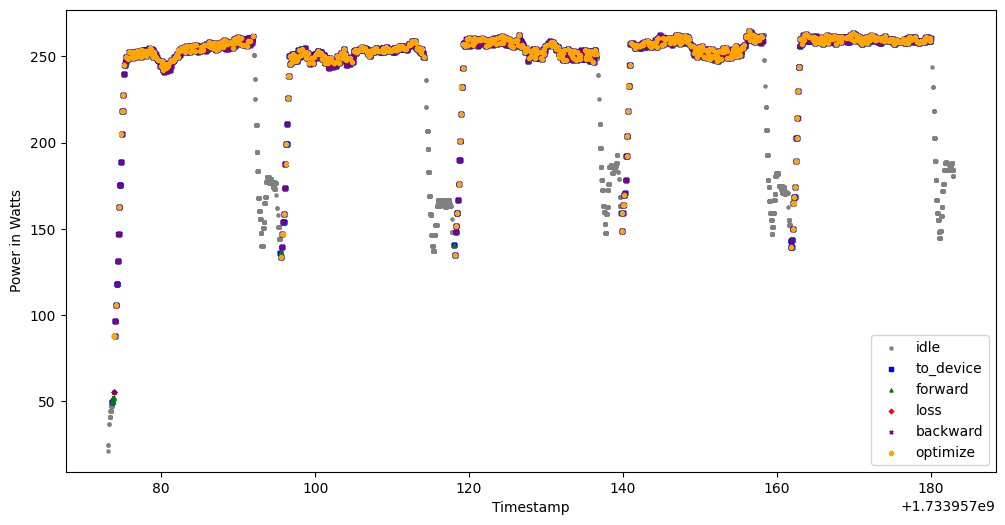

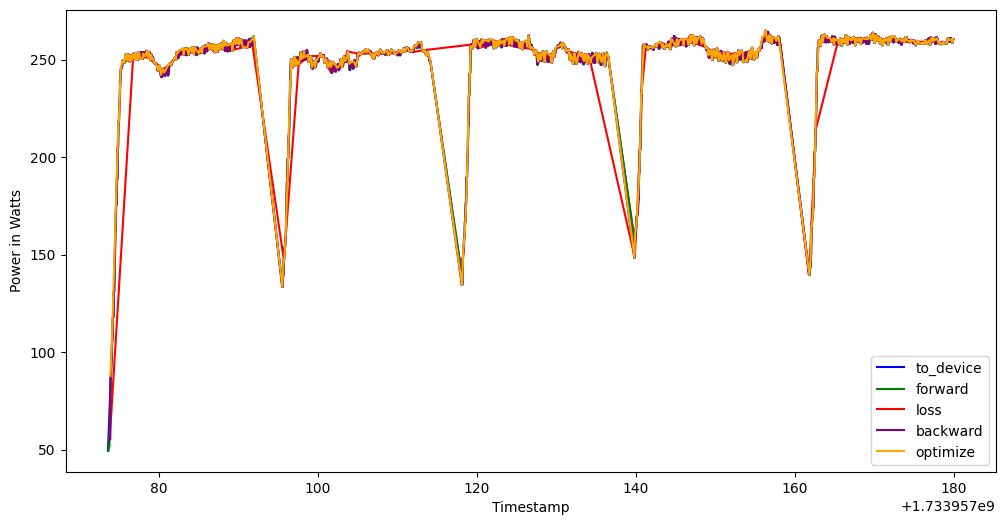

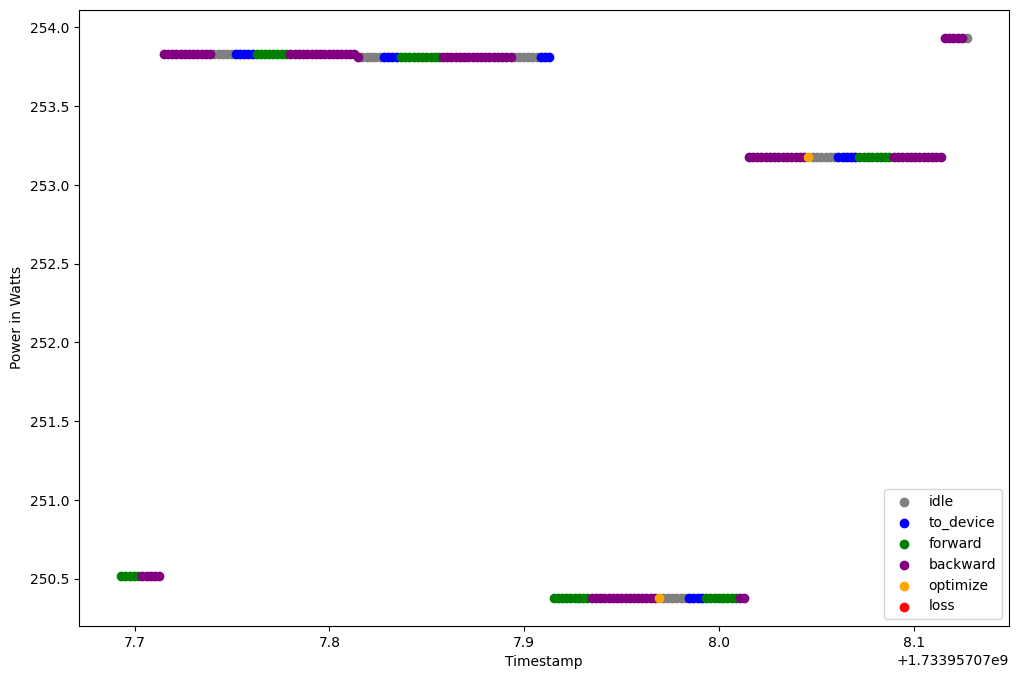

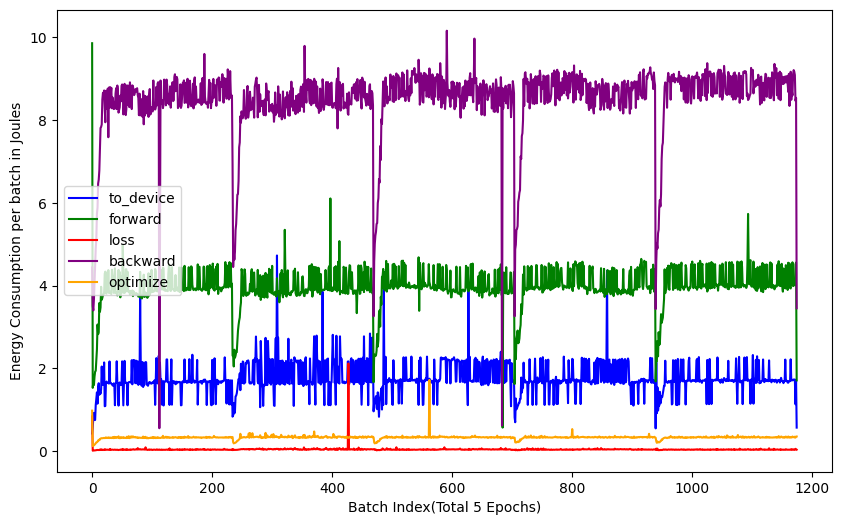

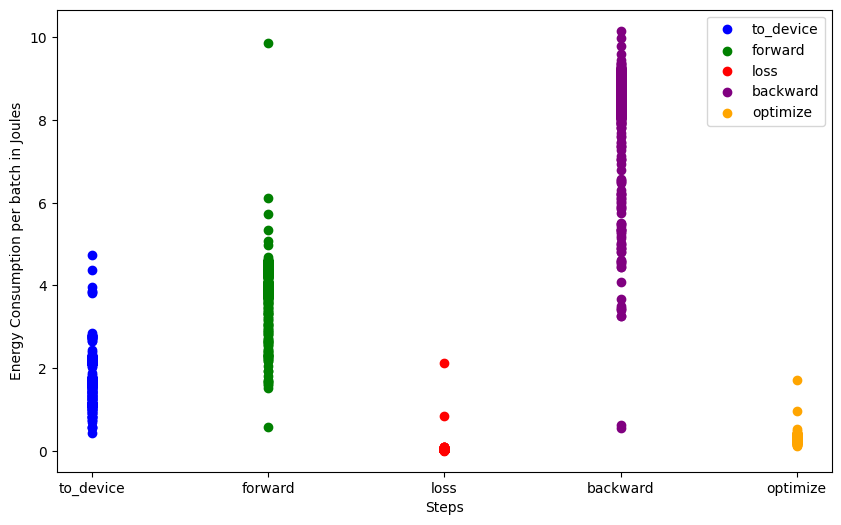

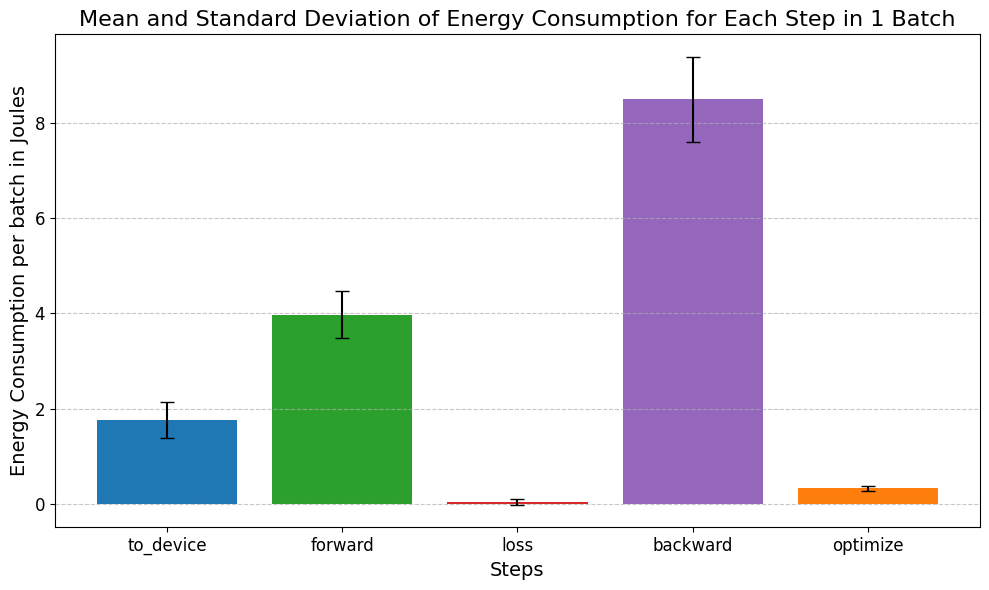

[[ 387.80135155  925.10920263    9.48903055 1952.79415174   76.57178391]
 [ 442.71674845  923.04855562   13.12420487 1958.0734704    79.60972455]
 [ 429.53245952  926.76910041    9.7380325  2003.39081051   79.34060626]
 [ 407.7994559   937.87959436    9.8139616  2018.00658217   78.19865191]
 [ 399.64145645  958.11994733    9.02810569 2043.73405445   77.89481399]]


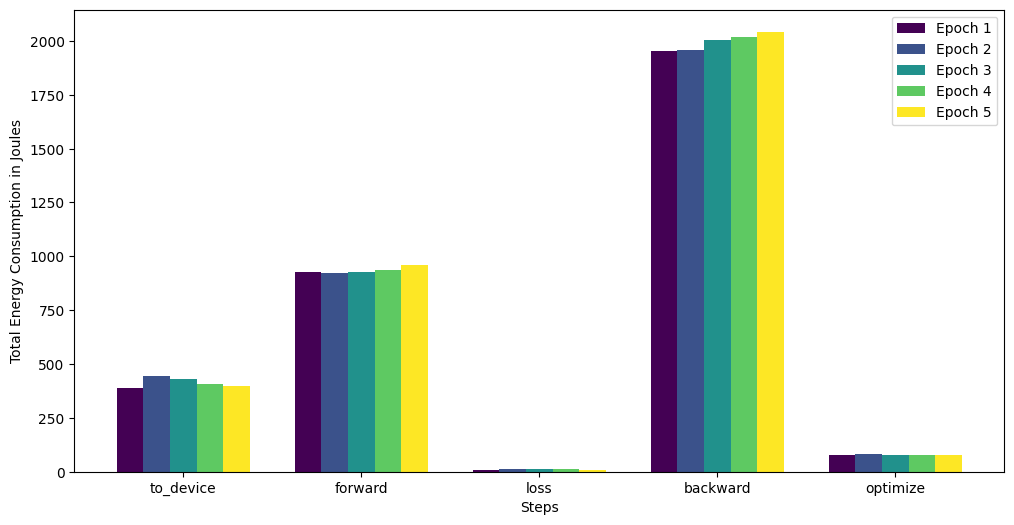

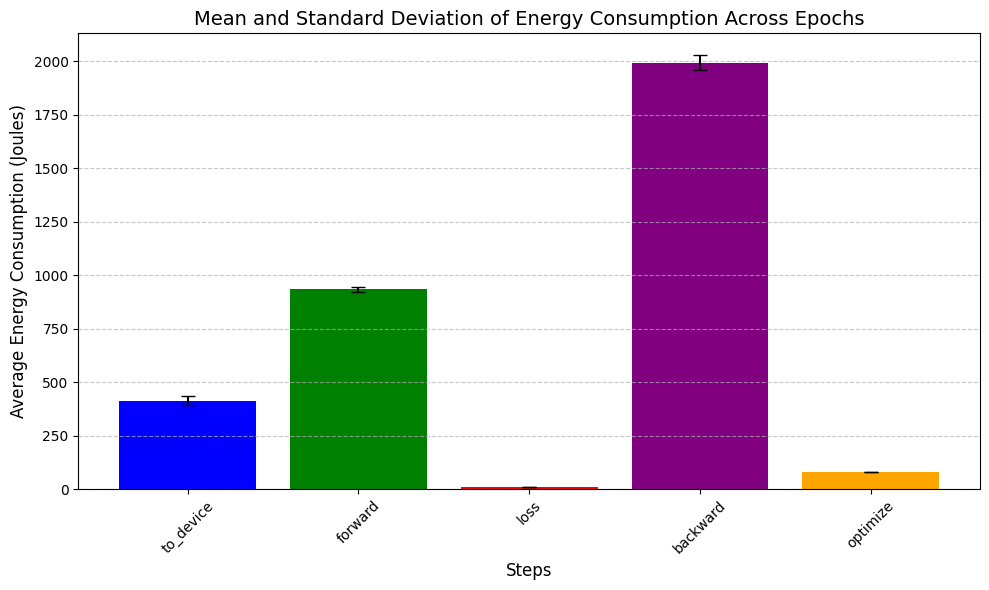

In [16]:
plot_model('alexnet', model_data_folder_list)

## ResNet

### ResNet18

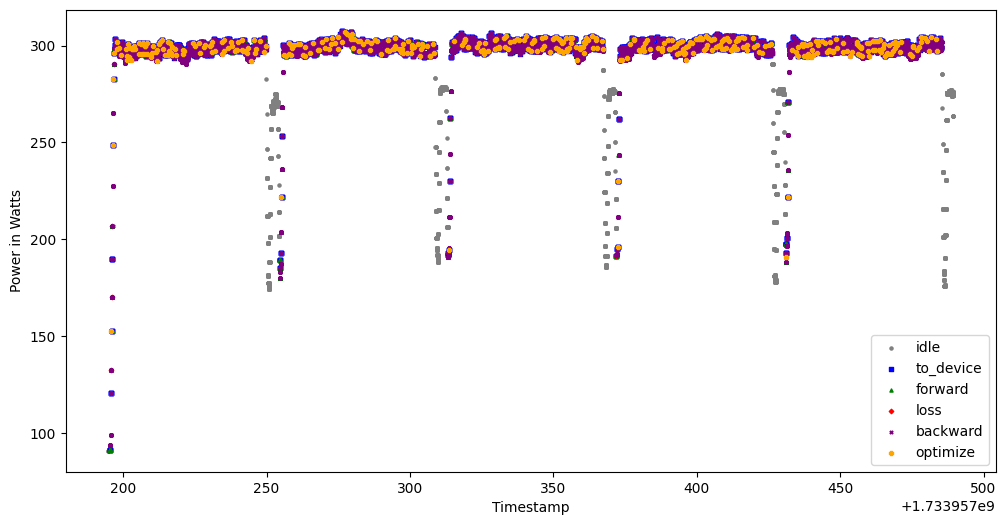

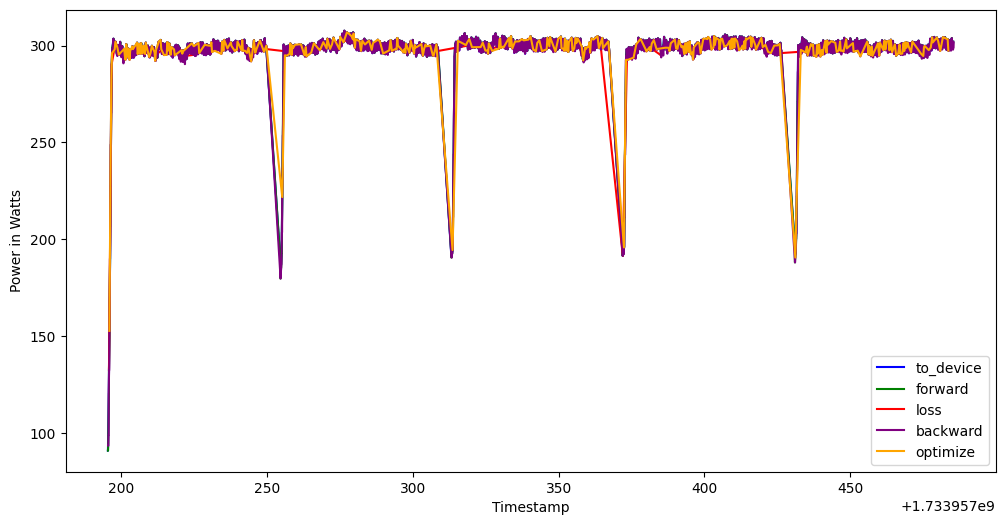

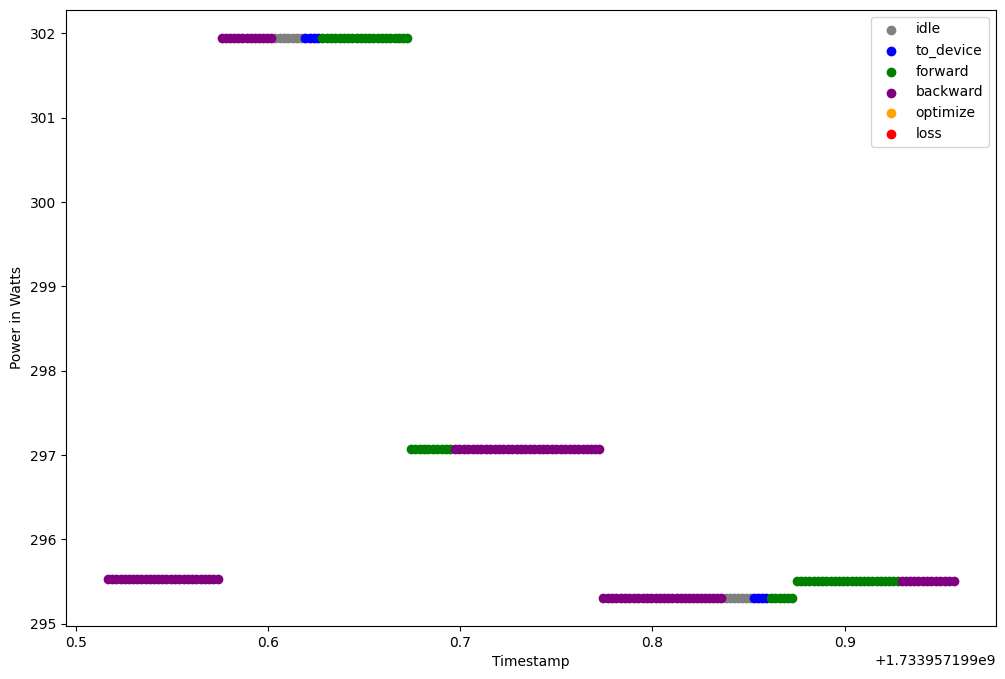

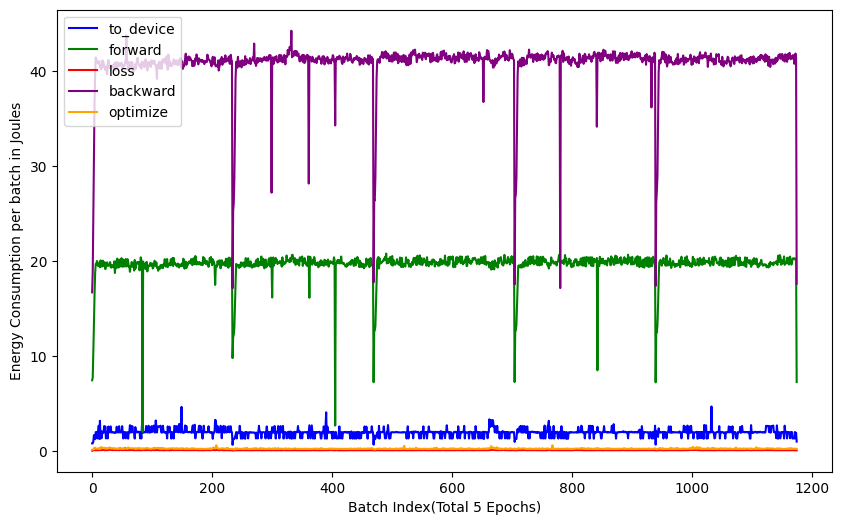

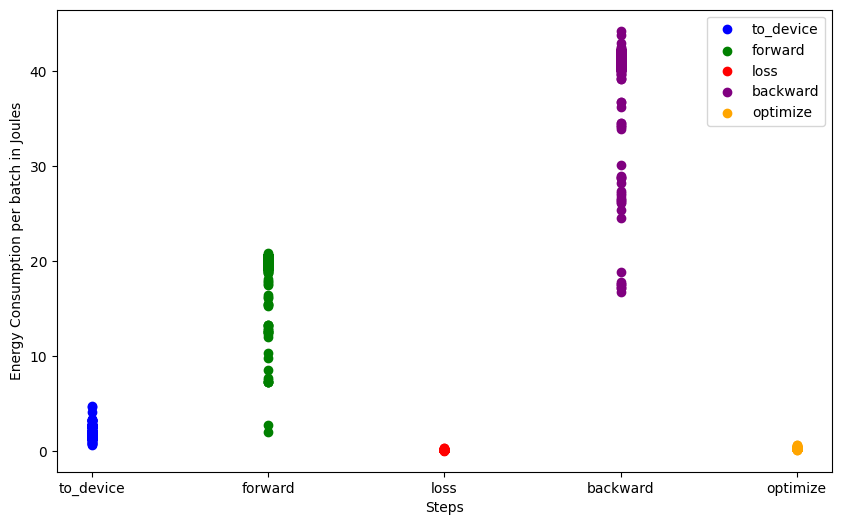

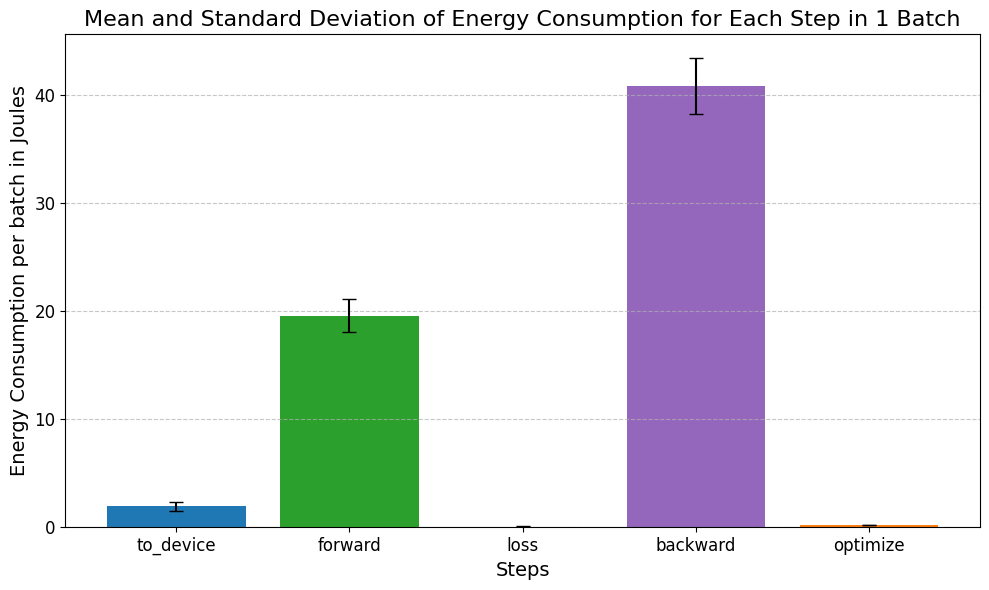

[[ 487.33448134 4554.44681727   19.68237249 9497.15518125   58.18575681]
 [ 437.45912343 4591.4281414    15.92385256 9588.47610445   51.69180249]
 [ 446.65294868 4639.96195441   16.68339689 9656.8153573    52.85450024]
 [ 454.45367396 4627.22216143   16.73834591 9618.52018769   52.54300448]
 [ 459.11779211 4625.00553955   17.44801894 9620.14437262   54.65272901]]


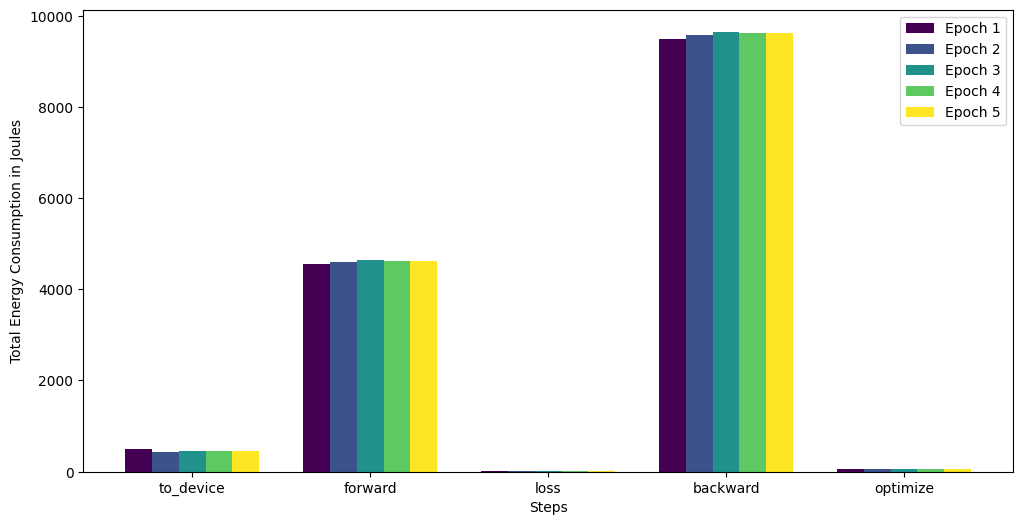

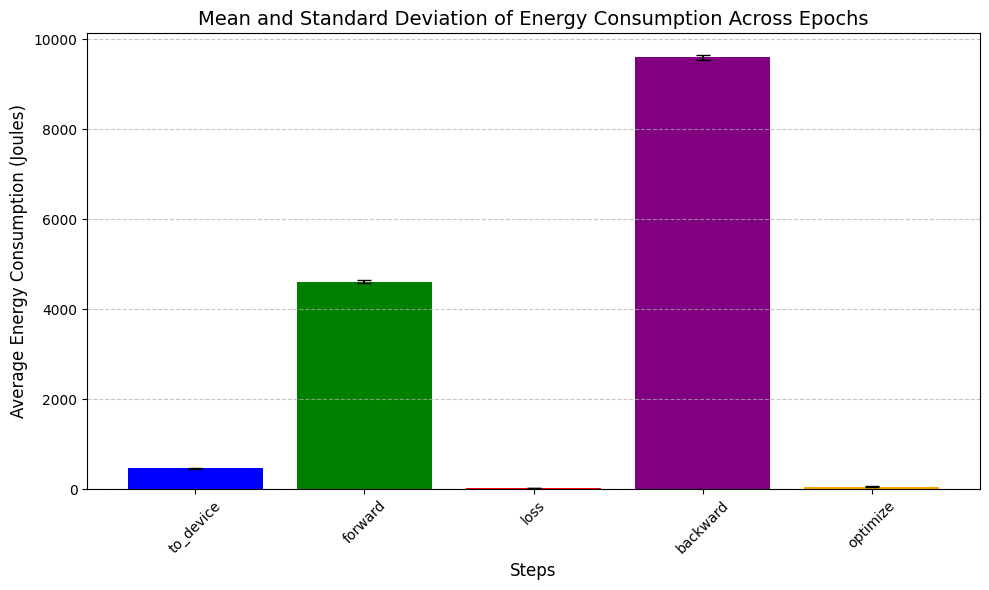

In [17]:
plot_model('resnet18', model_data_folder_list)

### ResNet34

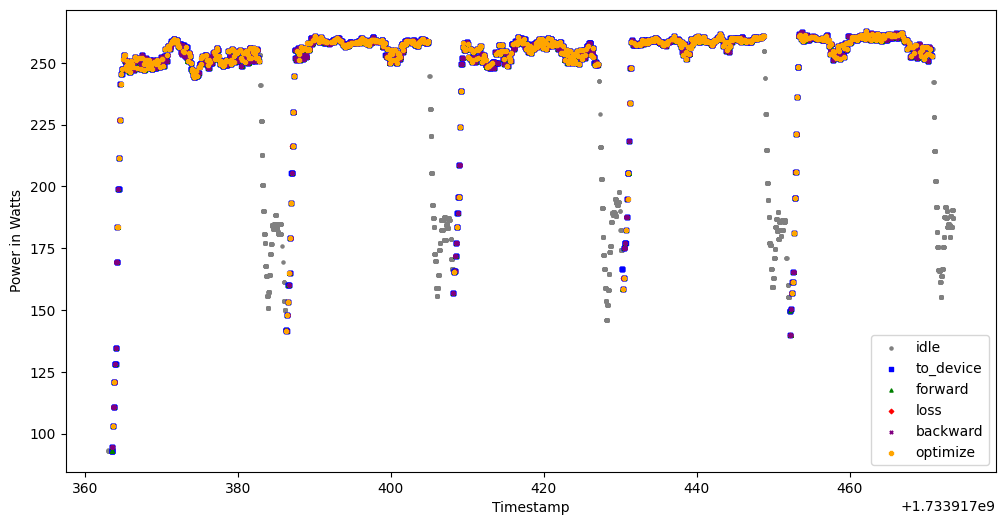

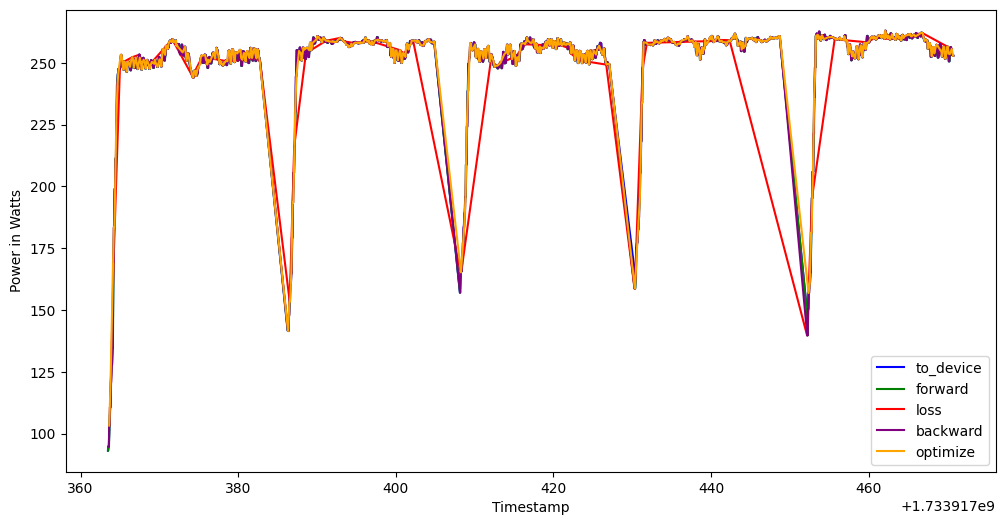

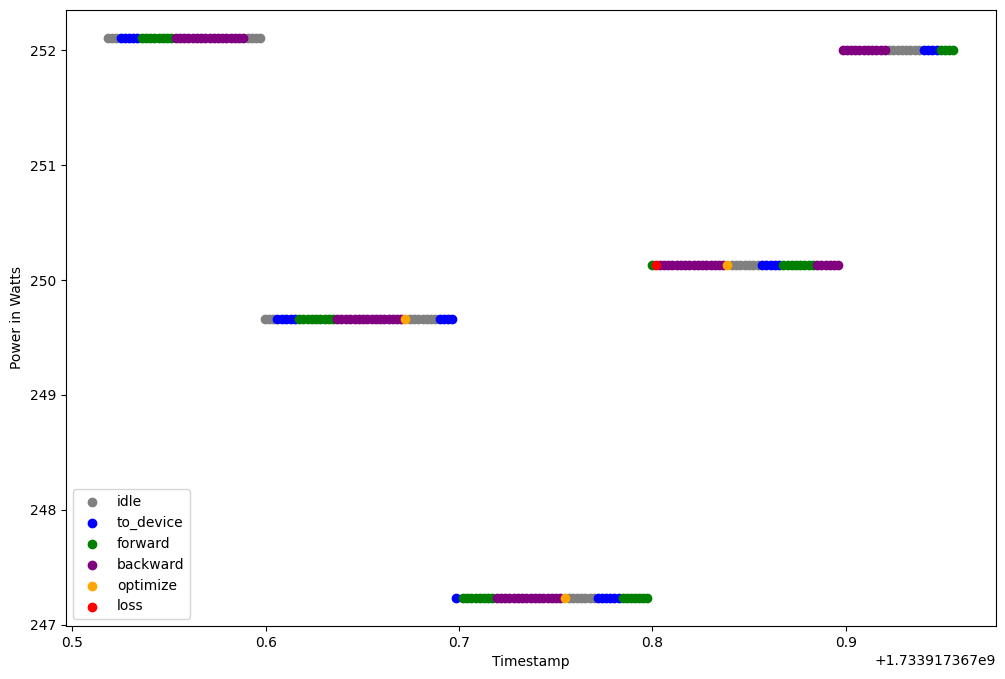

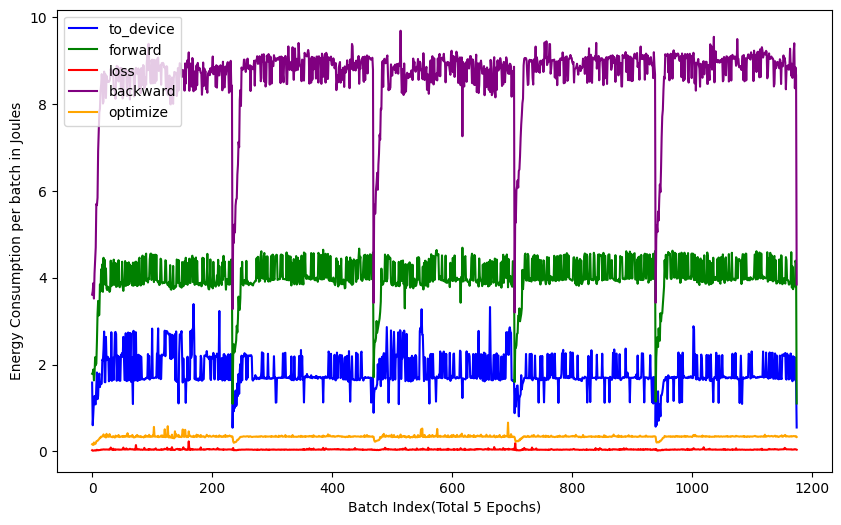

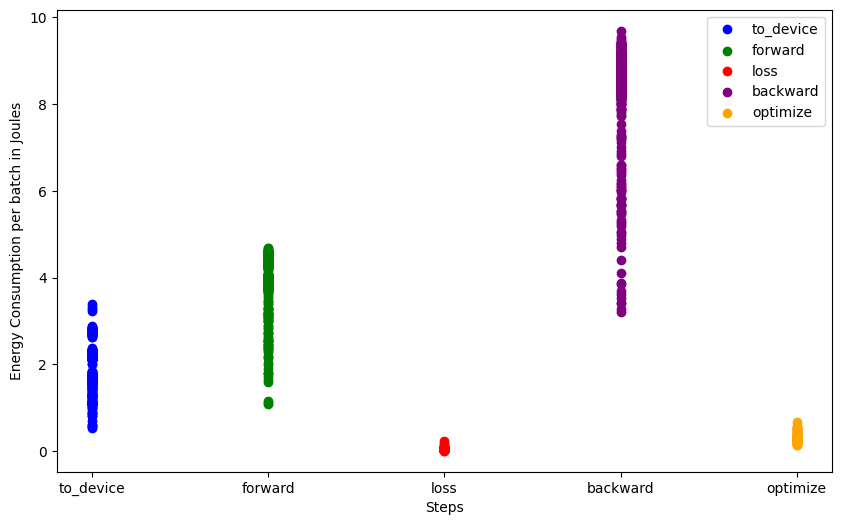

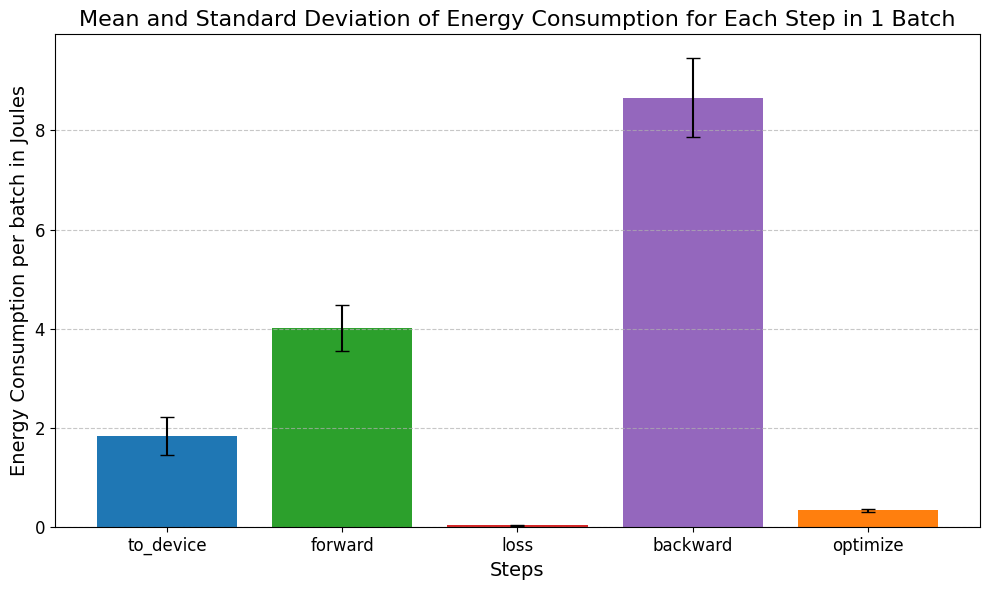

[[ 468.78417708  921.12148997   11.32740251 1981.03923556   80.90024232]
 [ 413.68802515  948.61081932   10.46049247 2048.77549589   80.07829775]
 [ 460.54473395  940.85991811   11.03882579 2024.85494145   81.2908591 ]
 [ 406.0824327   961.72507211   10.51314958 2062.39084992   80.00601922]
 [ 412.94615515  952.30912398   10.55461591 2060.89202563   80.26478627]]


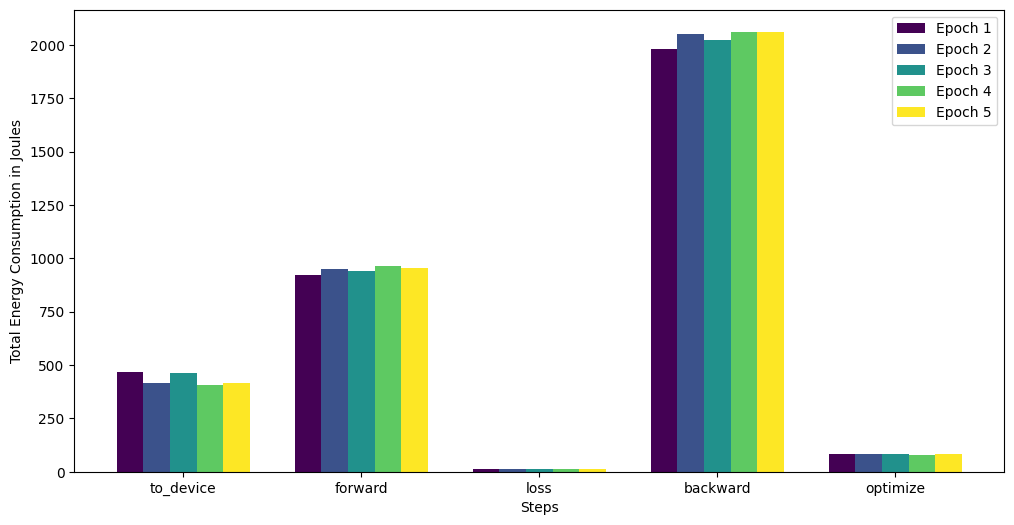

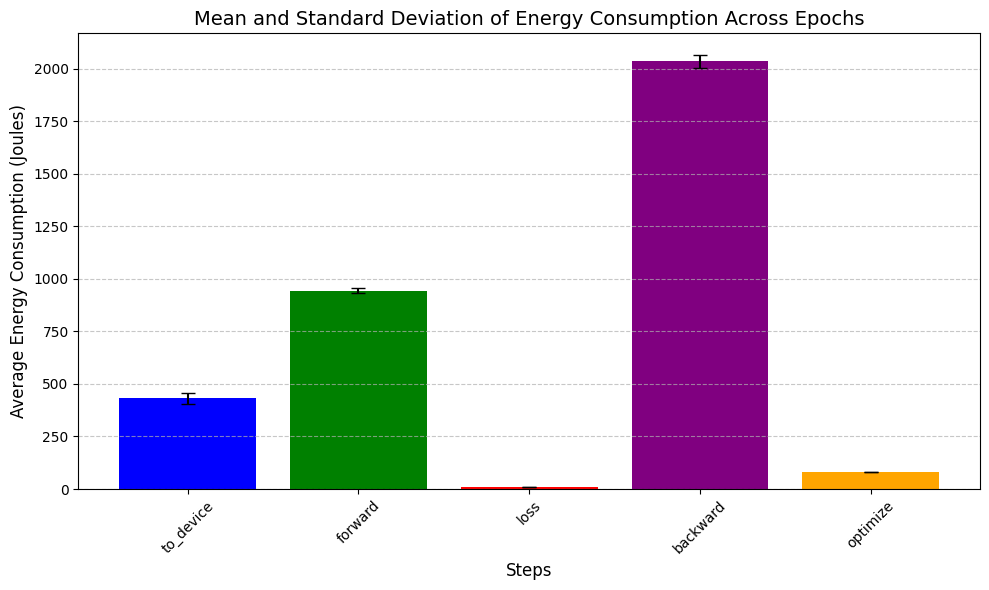

In [18]:
plot_model('resnet34', model_data_folder_list)

### ResNet50

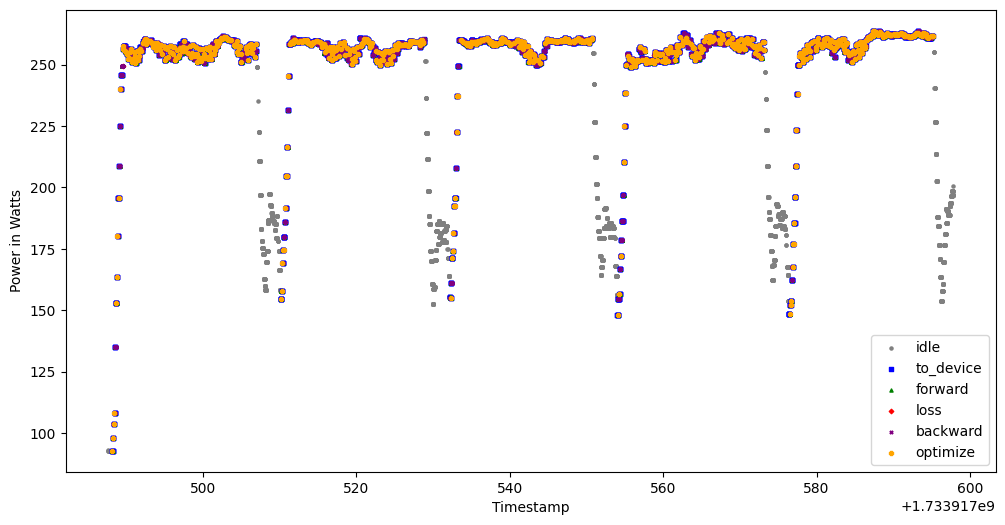

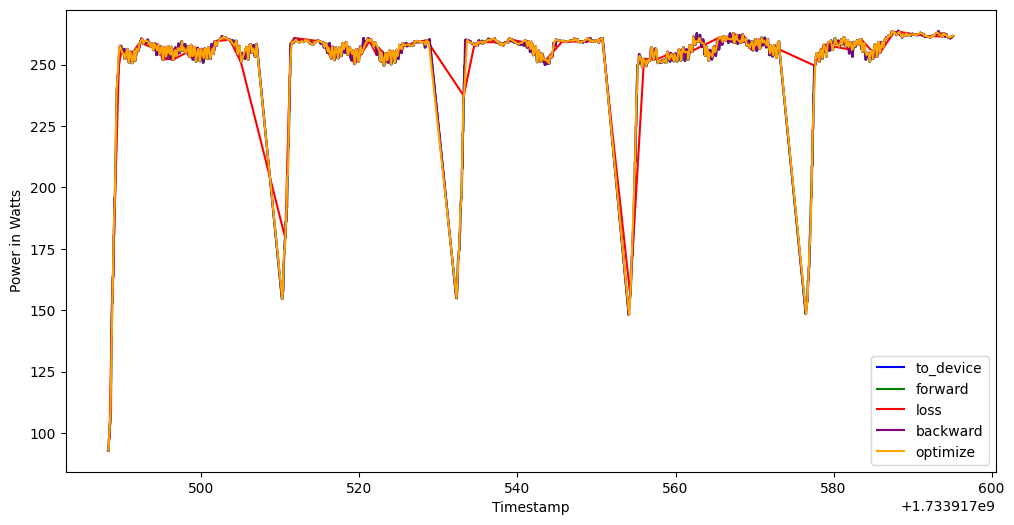

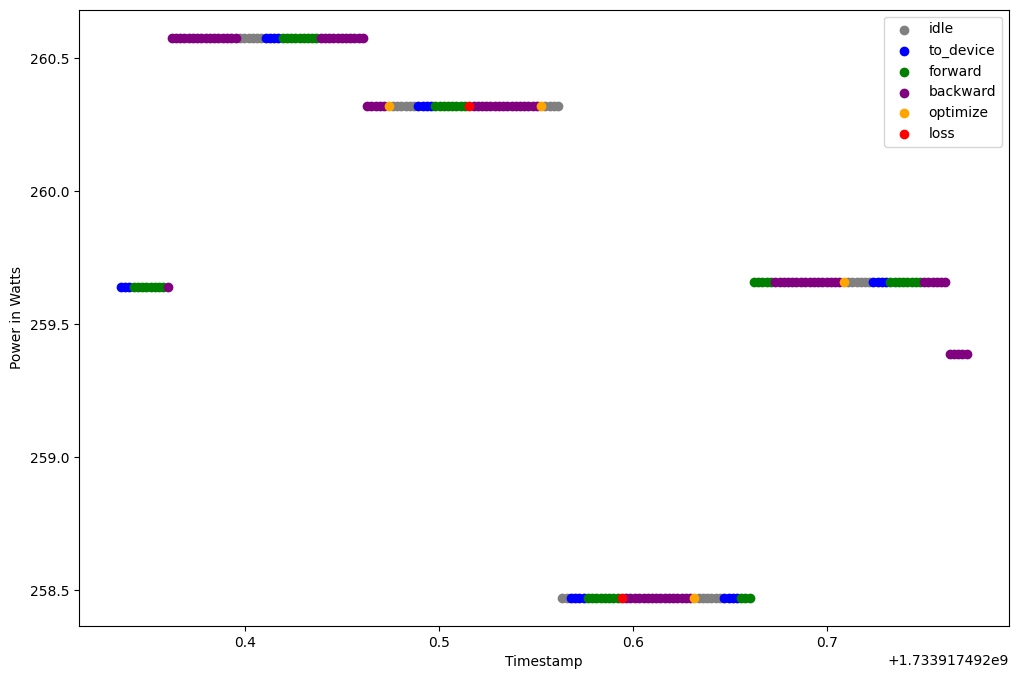

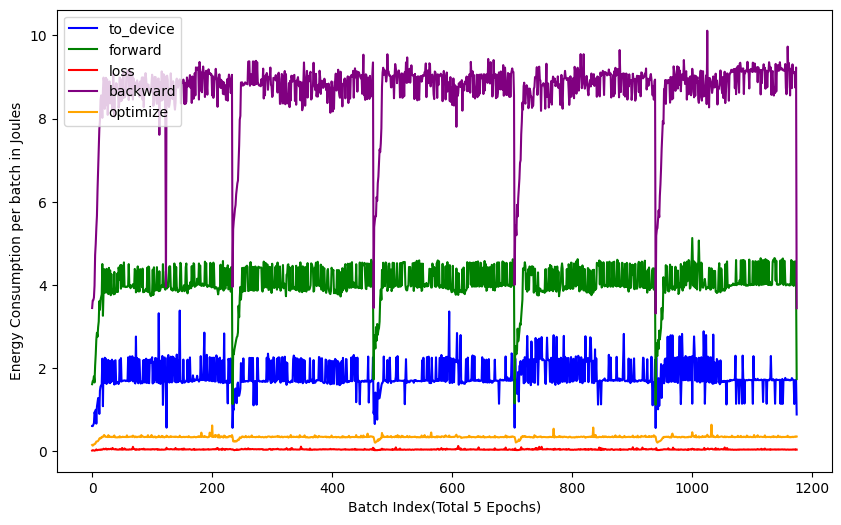

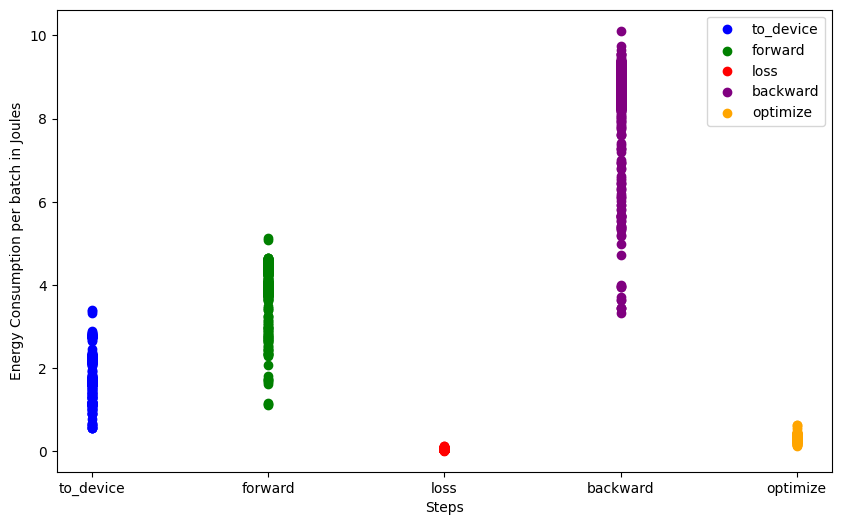

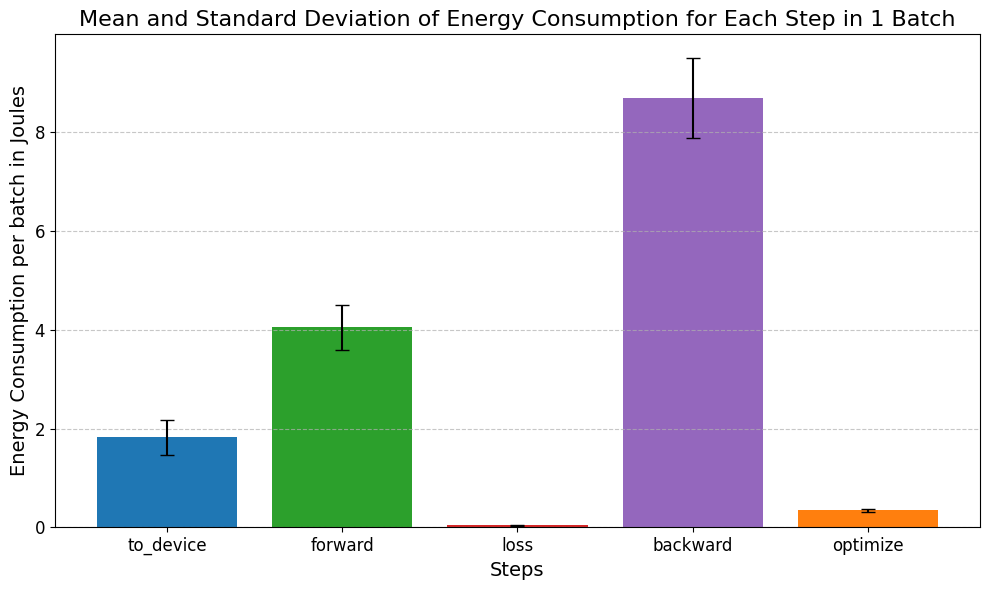

[[ 427.5293992   927.91625016   11.26185014 2003.34617843   81.05968737]
 [ 424.72946978  951.84926327   11.11307293 2039.69618581   80.74375722]
 [ 418.20528673  957.71588644   10.63670695 2055.77874408   80.93540191]
 [ 449.79054889  954.09318832   11.37767791 2044.07424165   81.34750052]
 [ 420.72455004  959.89355891   10.73196788 2068.93357378   81.51176641]]


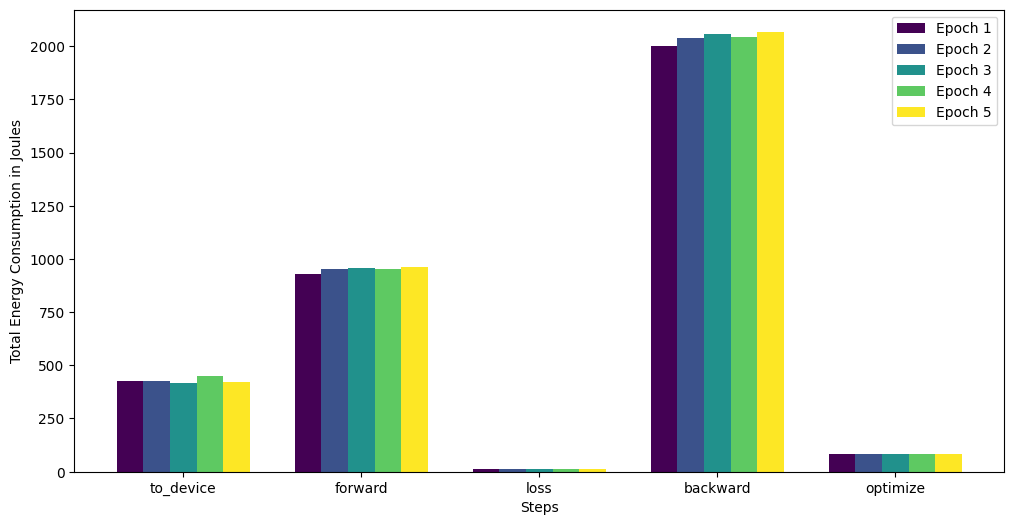

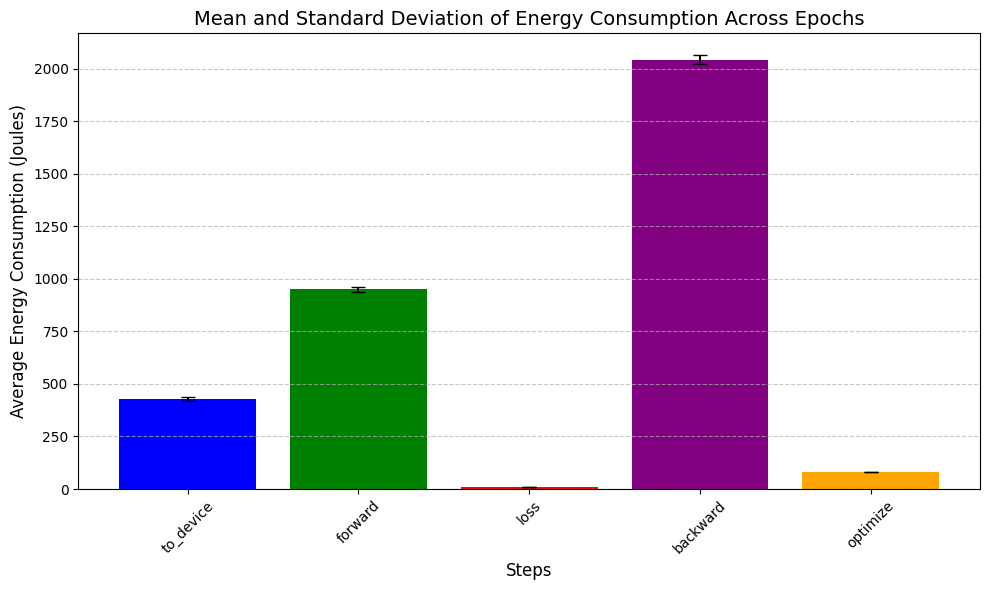

In [19]:
plot_model('resnet50', model_data_folder_list)

## VGG

### VGG11

In [20]:
plot_model('vgg11', model_data_folder_list)

FileNotFoundError: [Errno 2] No such file or directory: '/root/autodl-tmp/GreenAI/3080/ModelsData/vgg11/E5_B256_R0_SR2/to_device_energy.npy'

### VGG13

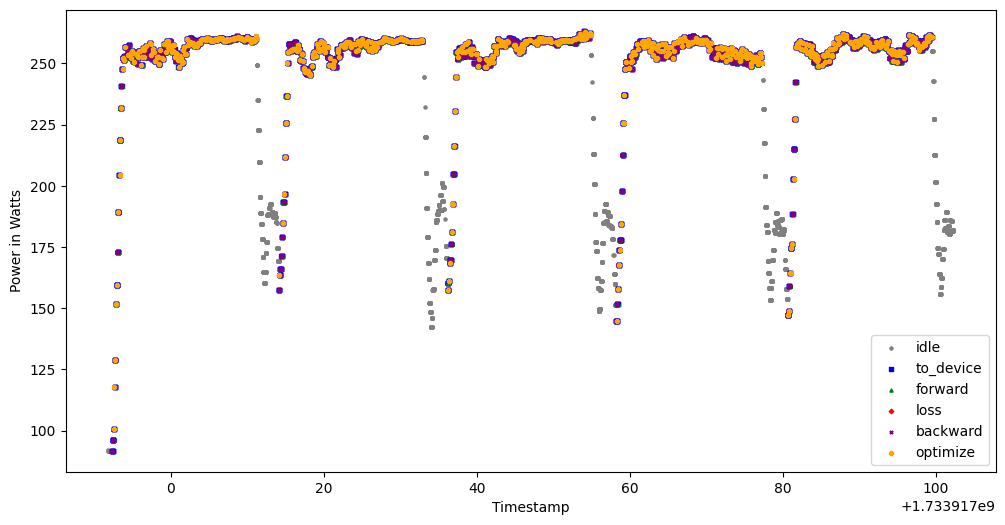

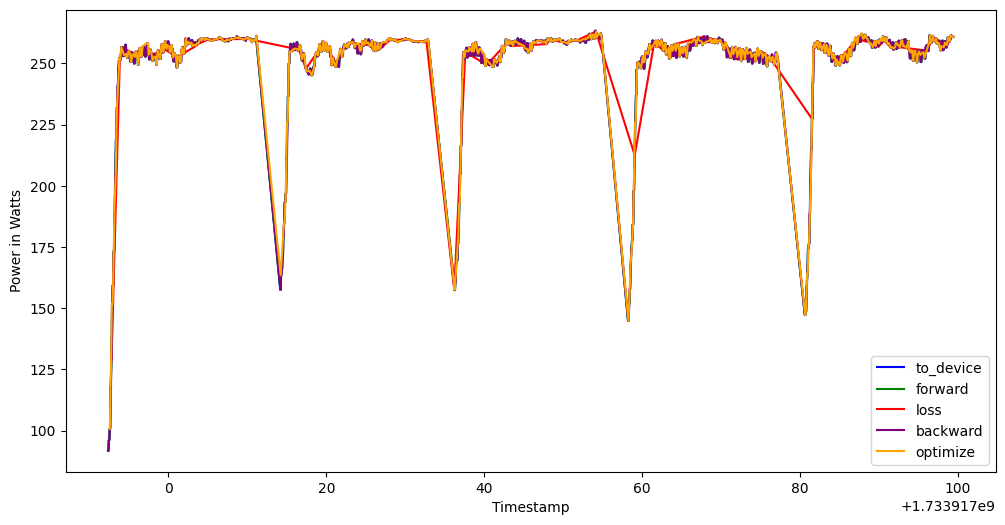

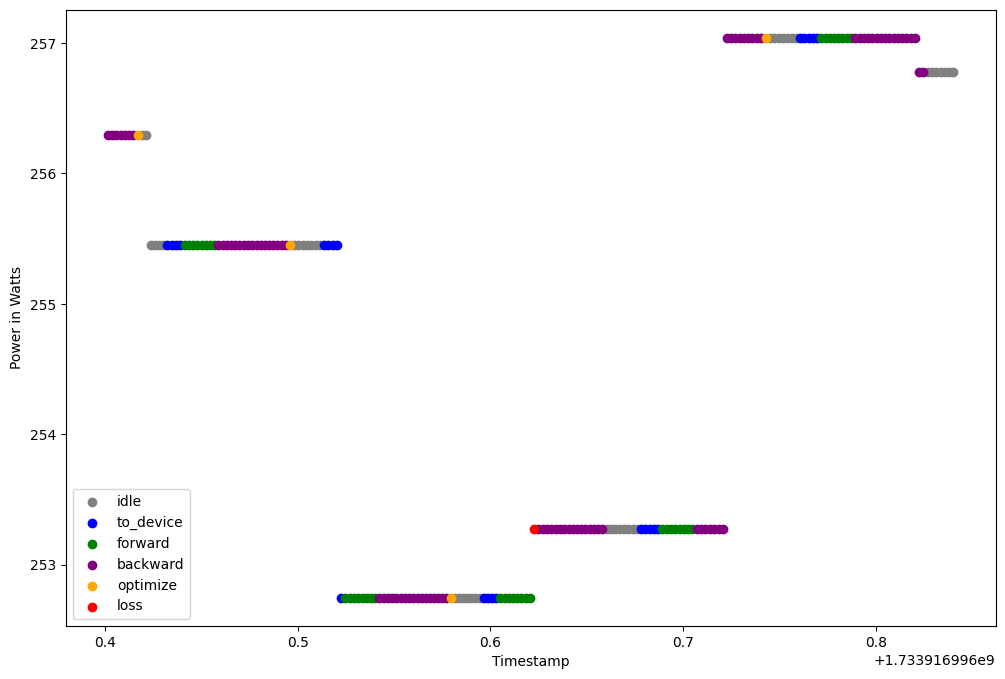

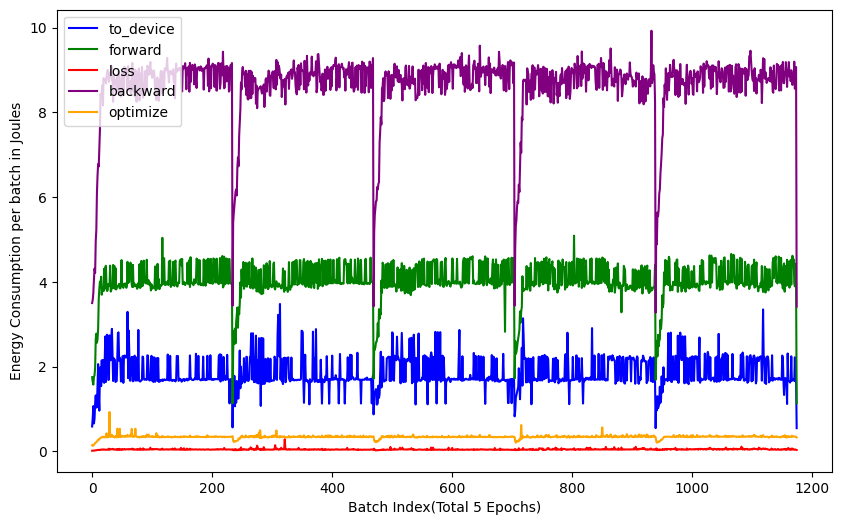

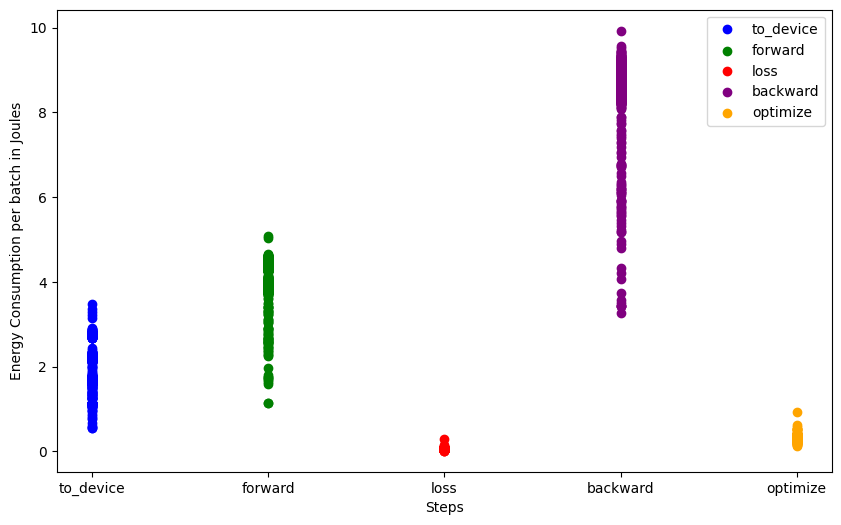

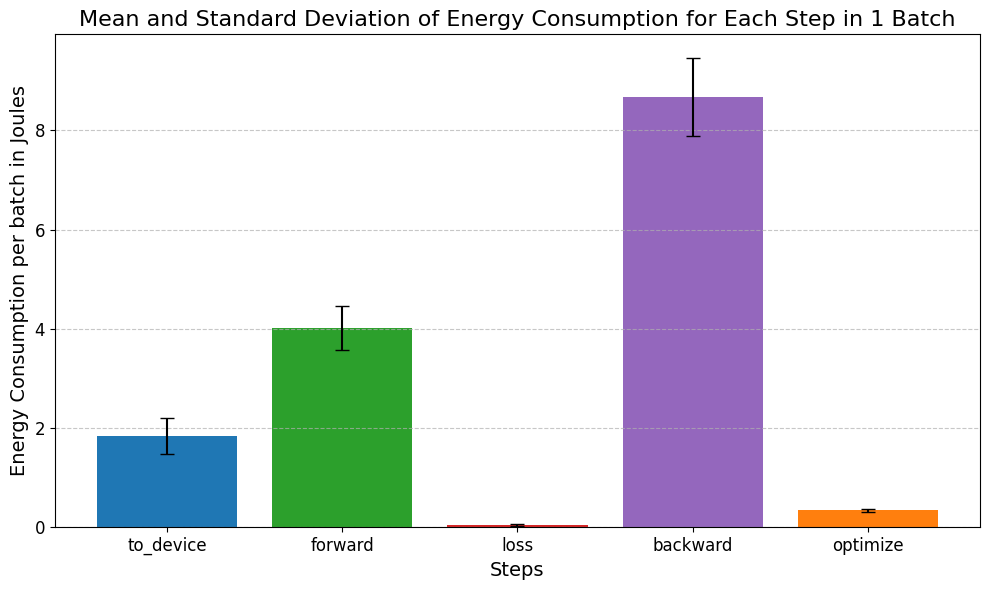

[[ 432.54855189  935.23006654   11.05766981 2024.5429974    81.30276118]
 [ 426.20934833  947.99608946   11.43336837 2041.08976866   80.88495823]
 [ 430.66448448  951.78461231   10.45182281 2048.97708942   80.01876566]
 [ 440.35804827  943.73023464   11.8716058  2034.26003415   81.68524645]
 [ 441.51771746  949.06657481   12.46415367 2039.77634764   81.40981993]]


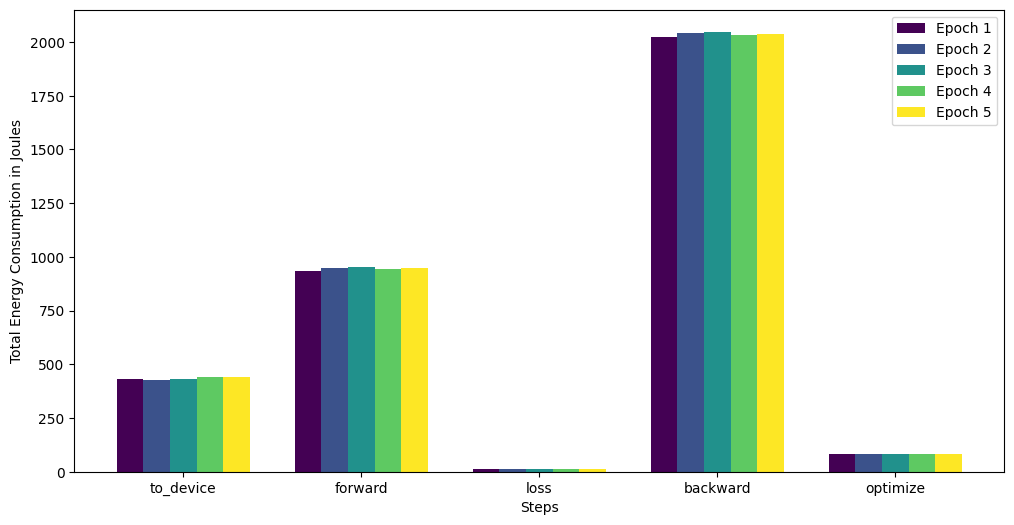

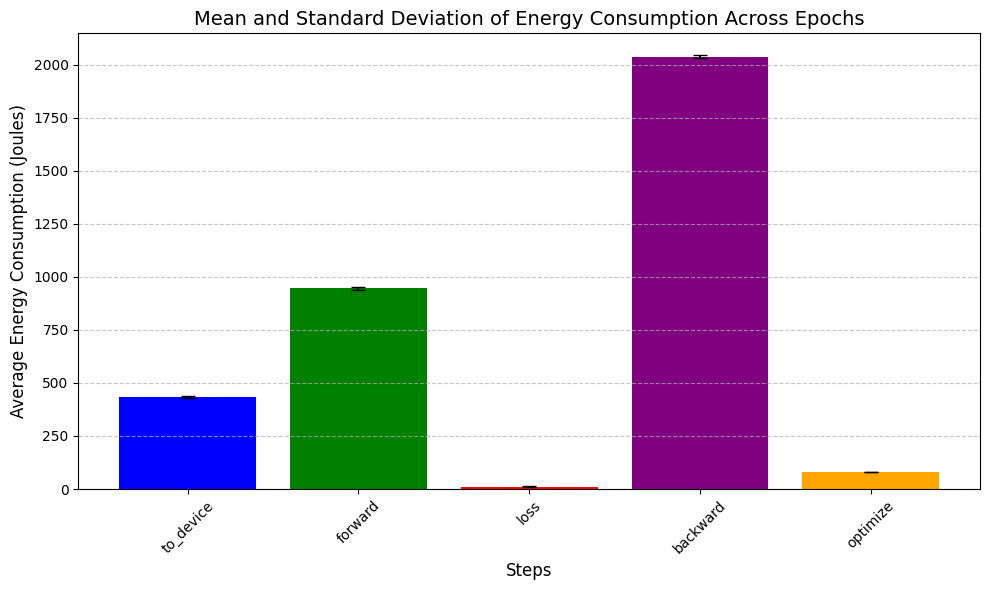

In [77]:
plot_model('vgg13', model_data_folder_list)

### VGG16

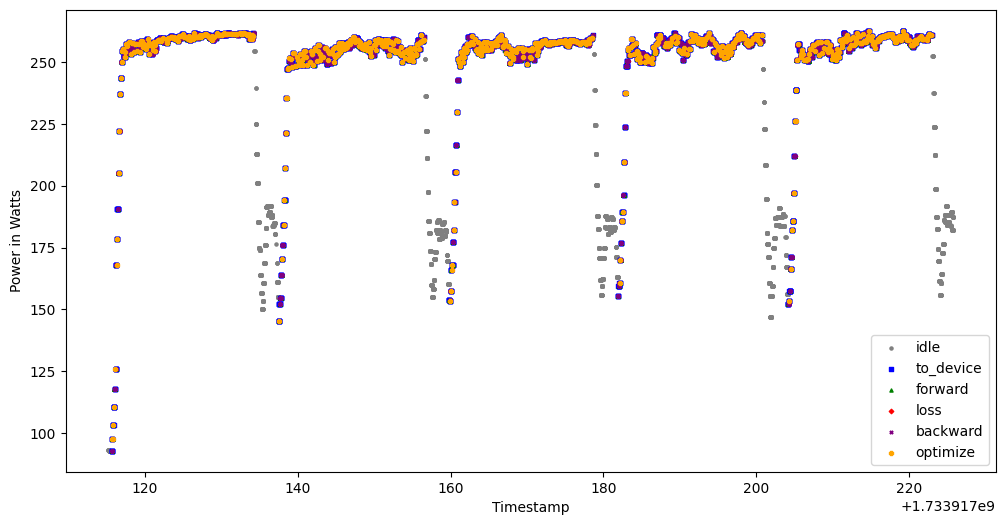

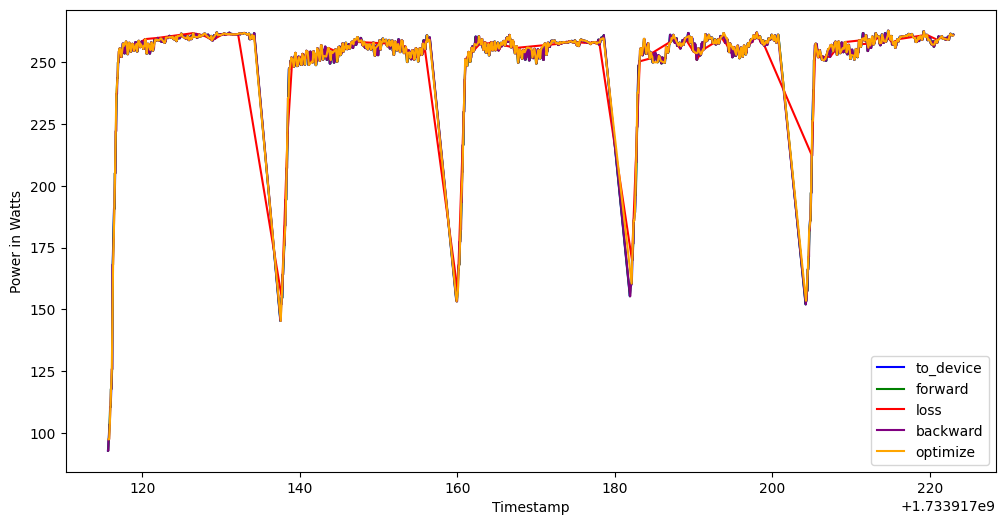

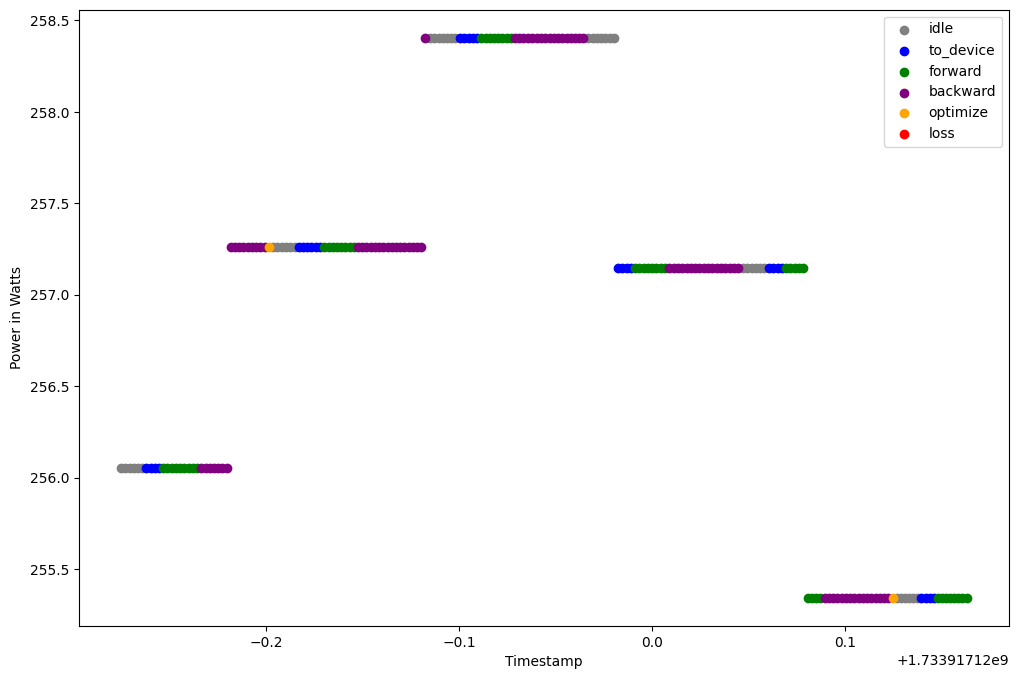

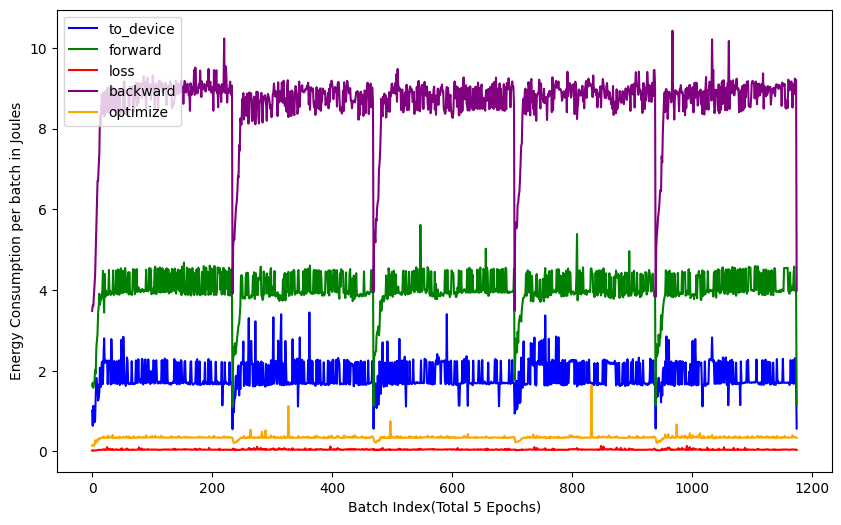

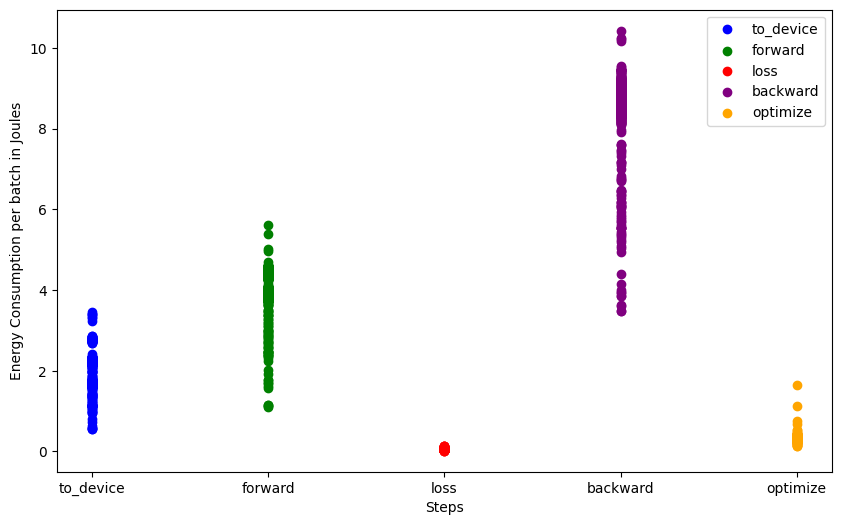

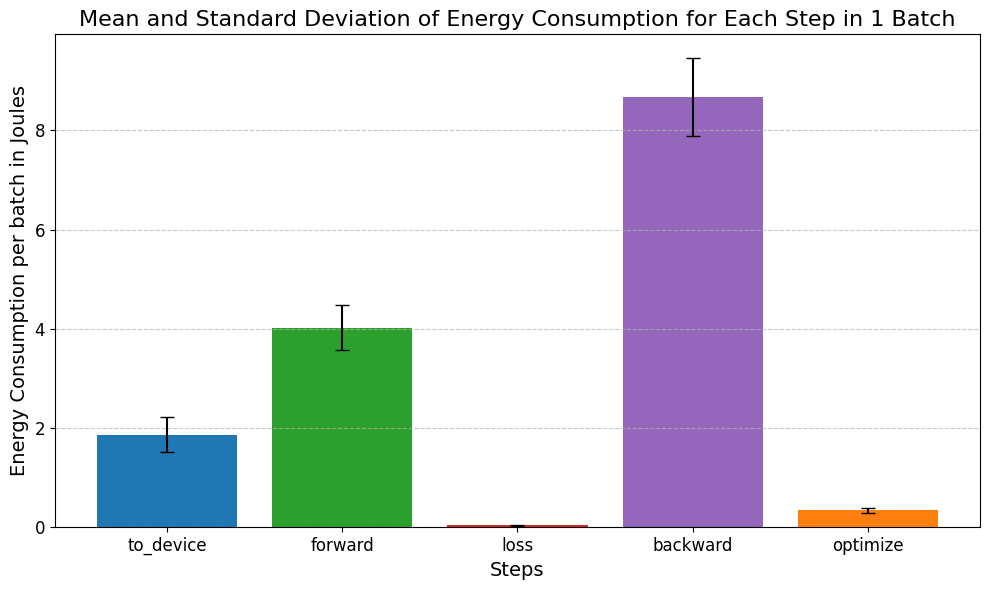

[[ 428.34189316  946.935574     10.69204314 2039.9076295    80.33732795]
 [ 451.13570015  939.21455957   11.85622014 2020.89293356   81.8990232 ]
 [ 432.48476708  946.38915183   10.97093792 2029.20036477   81.02223885]
 [ 448.08393206  945.70142033   11.1912968  2049.12625601   82.07961038]
 [ 438.24973684  951.78161079   11.0044228  2054.30338515   81.82522405]]


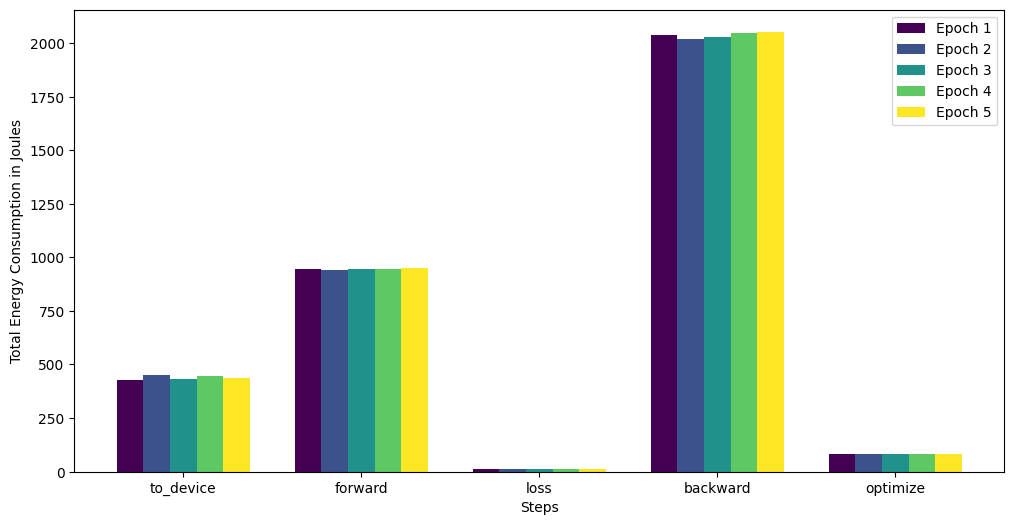

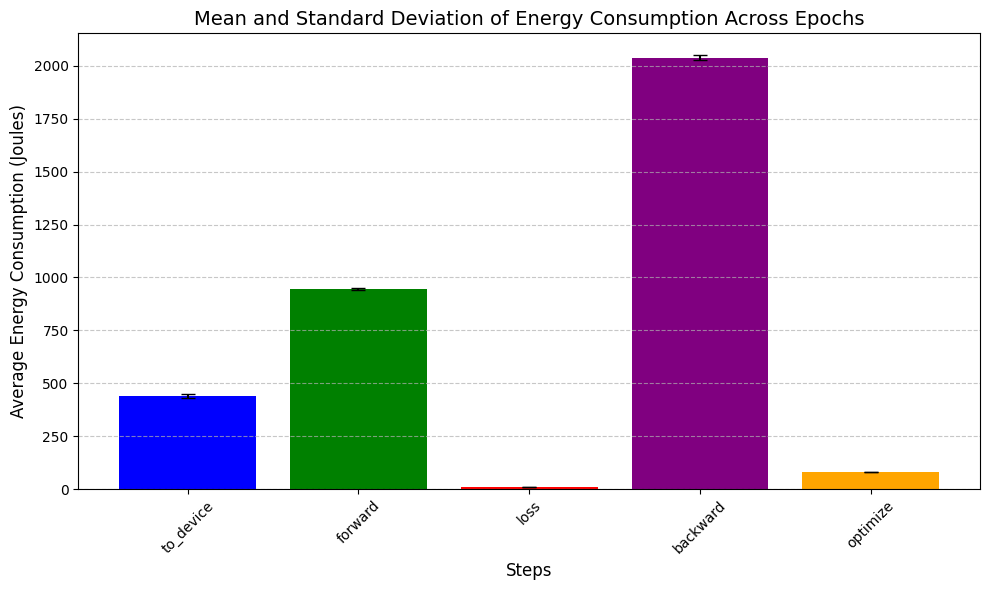

In [78]:
plot_model('vgg16', model_data_folder_list)

## 分析设定的采样频率与真实的采样数据量之间的关系

In [79]:
# Calculate the total energy consumption for all the labeled_energy_data
# count the number of rows in the labeled_energy_data, which is the number of samples
number_of_samples = labeled_energy_data.shape[0]
print('Number of samples:', number_of_samples)

# get the start and end time of the labeled_energy_data
start_time = labeled_energy_data['timestamp'].iloc[0]
end_time = labeled_energy_data['timestamp'].iloc[-1]
print('Start time:', start_time)
print('End time:', end_time)

# Calculate the theorectical number of samples based on the sampling rate
sample_rate = 0.002 # 2ms
theoretical_number_of_samples = np.round((end_time - start_time) / sample_rate)
print('Theoretical number of samples:', theoretical_number_of_samples)

# calculate the missing rate
missing_rate = 1 - number_of_samples / theoretical_number_of_samples
print('Missing rate:', missing_rate)

NameError: name 'labeled_energy_data' is not defined